In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [2]:
no_epochs = 50
learning_rate = 0.0001
batch_size = 128
num_classes = 102

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

acc_function = MulticlassAccuracy(num_classes=102, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss()

SEED = 196
np.random.seed(SEED)
generator = torch.Generator().manual_seed(SEED)

cuda:0


In [3]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

default_transforms = transforms.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
def get_data_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=generator)
    return train_loader, test_loader, val_loader

In [5]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, train_time = [], [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        time_taken = (end-start).total_seconds()
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Train Time: {time_taken:>0.2f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        train_time.append(time_taken)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc:>0.2f}%, Test Loss: {test_loss:>8f}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, train_time

In [7]:
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=102):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                        
        new_last_layer_1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu2', nn.ReLU(inplace=True)),
            ('downsample', nn.Sequential(OrderedDict([
                ('0', nn.Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
                ('1', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            ])))
        ]))
        
        new_last_layer_2 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer_3 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv2', nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
            ('bn2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('conv3', nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)),
            ('bn3', nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
            ('relu', nn.ReLU(inplace=True))
        ]))
        
        new_last_layer = nn.Sequential(OrderedDict([
            ('1', new_last_layer_1),
            ('2', new_last_layer_2),
            ('3', new_last_layer_3)
        ]))
        self.resnet.layer4 = new_last_layer
        self.resnet.fc = nn.Linear(2048, num_classes, bias=True)
        
    def forward(self, x):
        return self.resnet(x)
    

In [8]:
train_data_loader, test_data_loader, val_data_loader = get_data_loader(batch_size)

In [11]:
class ResNet34WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34WithSE, self).__init__()
        self.resnet = torchvision.models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        self.resnet.layer1.add_module('SEBlock', torchvision.ops.SqueezeExcitation(64, 16))
        self.resnet.layer4.add_module('SEBlock', torchvision.ops.SqueezeExcitation(512, 16))
        self.resnet.fc = nn.Linear(512, num_classes)

        
    def forward(self, x):
        x = self.resnet(x)
        return x


SE_model = ResNet34WithSE(num_classes)

SE_model = SE_model.to(device=device)

In [13]:
model_epochs = 5

In [14]:
base_eval_acc_arr, base_test_acc_arr, base_time_taken_arr = [], [], []
modified_eval_acc_arr, modified_test_acc_arr, modified_time_taken_arr = [], [], []
SE_eval_acc_arr, SE_test_acc_arr, SE_time_taken_arr = [], [], []

for i in range(model_epochs):
    
    base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    base_model.fc = nn.Linear(512, 102)
    base_model = base_model.to(device)
    base_train_acc, base_train_loss, base_eval_loss, base_eval_acc, base_test_acc, base_test_loss, base_train_time = train_eval_test(
        base_model, 
        train_data_loader, 
        val_data_loader, 
        test_data_loader,
        no_epochs=no_epochs
    )
        
    base_eval_acc_arr.append(np.mean(base_eval_acc))
    base_test_acc_arr.append(base_test_acc)
    base_time_taken_arr.append(np.mean(base_train_time))
    
    del base_model
    
    
    modified_model = ModifiedResNet().to(device)
    modified_train_acc, modified_train_loss, modified_eval_loss, modified_eval_acc, modified_test_acc, modified_test_loss, modified_train_time = train_eval_test(
        modified_model, 
        train_data_loader, 
        val_data_loader, 
        test_data_loader,
        no_epochs=no_epochs
    )

    modified_eval_acc_arr.append(np.mean(modified_eval_acc))
    modified_test_acc_arr.append(modified_test_acc)
    modified_time_taken_arr.append(np.mean(modified_train_time))
    
    del modified_model
    
    
    SE_model = ResNet34WithSE(num_classes)

    SE_model = SE_model.to(device=device)
    SE_train_acc, SE_train_loss, SE_eval_loss, SE_eval_acc, SE_test_acc, SE_test_loss, SE_train_time = train_eval_test(
        SE_model, 
        train_data_loader, 
        val_data_loader, 
        test_data_loader,
        no_epochs=no_epochs
    )

    del SE_model
    
    SE_eval_acc_arr.append(np.mean(SE_eval_acc))
    SE_test_acc_arr.append(SE_test_acc)
    SE_time_taken_arr.append(np.mean(SE_train_time))
    

Epoch 1 Train Loss: 4.592120, Eval Accuracy: 15.32%, Eval Loss: 3.996889, Train Time: 12.46s
Epoch 2 Train Loss: 3.653284, Eval Accuracy: 47.15%, Eval Loss: 3.216567, Train Time: 9.30s
Epoch 3 Train Loss: 2.834914, Eval Accuracy: 67.34%, Eval Loss: 2.569592, Train Time: 9.26s
Epoch 4 Train Loss: 2.235977, Eval Accuracy: 75.87%, Eval Loss: 2.067852, Train Time: 9.40s
Epoch 5 Train Loss: 1.774195, Eval Accuracy: 79.61%, Eval Loss: 1.682817, Train Time: 9.56s
Epoch 6 Train Loss: 1.390882, Eval Accuracy: 83.55%, Eval Loss: 1.379688, Train Time: 9.52s
Epoch 7 Train Loss: 1.125768, Eval Accuracy: 87.97%, Eval Loss: 1.135820, Train Time: 9.60s
Epoch 8 Train Loss: 0.917505, Eval Accuracy: 87.16%, Eval Loss: 0.971901, Train Time: 9.37s
Epoch 9 Train Loss: 0.733289, Eval Accuracy: 89.70%, Eval Loss: 0.835197, Train Time: 9.37s
Epoch 10 Train Loss: 0.603535, Eval Accuracy: 90.30%, Eval Loss: 0.736045, Train Time: 9.22s
Epoch 11 Train Loss: 0.506020, Eval Accuracy: 91.46%, Eval Loss: 0.656032, Tra

In [15]:
eval_acc = [np.mean(base_eval_acc_arr), np.mean(modified_eval_acc_arr), np.mean(SE_eval_acc_arr)]
test_acc = [np.mean(base_test_acc_arr), np.mean(modified_test_acc_arr), np.mean(SE_test_acc_arr)]
time_taken = [np.mean(base_time_taken_arr), np.mean(modified_time_taken_arr), np.mean(SE_time_taken_arr)]
names = ['base', 'modified', 'SE']
colours = ['tab:red', 'tab:blue', 'tab:green']

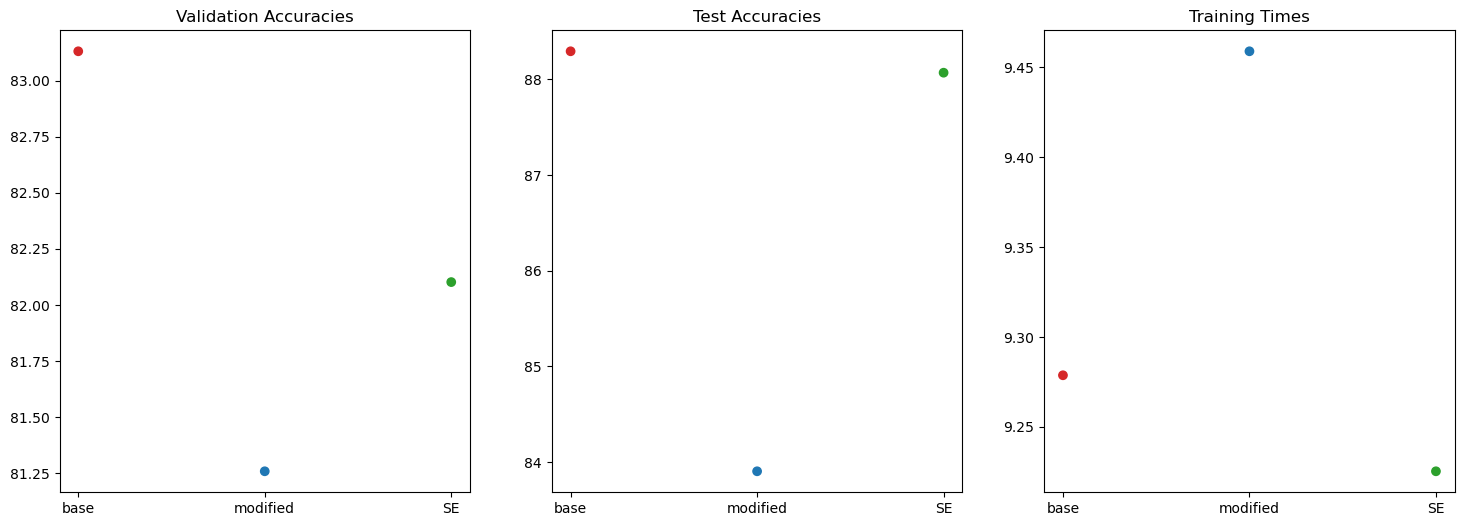

In [16]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title('Validation Accuracies')
plt.scatter(names, eval_acc, color=colours)
plt.subplot(132)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(133)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()

In [20]:
data = {'Names': names, 'Eval_Acc': eval_acc, 'Test_Acc': test_acc, 'Time_Taken': time_taken}

df = pd.DataFrame(data)
df

,Names,Eval_Acc,Test_Acc,Time_Taken
0,base,83.130376,88.293367,9.278725
1,modified,81.259389,83.903699,9.458951
2,SE,82.102201,88.069515,9.225316
